# shallow and deep neural networks

here we will explore shallow and deep neural networks



In [102]:
from collections import defaultdict
from tqdm import tqdm 
import torch
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## generate data

Text(0, 0.5, 'Y')

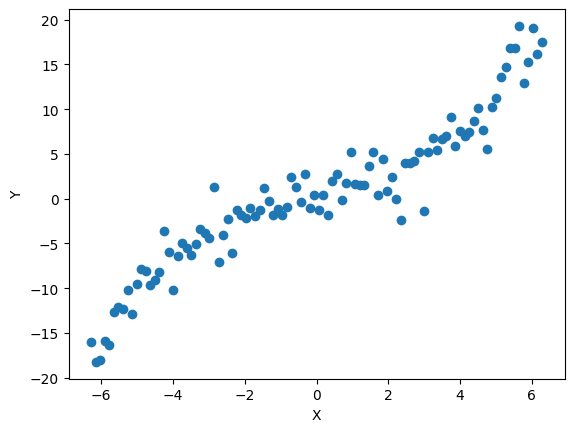

In [103]:
N = 100
X = torch.linspace(-2*torch.pi, 2*torch.pi, N).view(-1, 1)

# create a function of your interest
Y = X + 0.02 * X ** 2 + 0.05 * X ** 3 + 2*torch.randn(N, 1)
fig = plt.figure()
plt.scatter(X, Y) 
plt.xlabel('X')
plt.ylabel('Y')

In [104]:
# N = 100
# X = torch.linspace(-2*torch.pi, 2*torch.pi, N).view(-1, 1)
# Y = torch.sin(X)

# fig = plt.figure()
# plt.plot(X, Y)
# plt.xlabel('X')
# plt.ylabel('Y')


In [105]:
class ShallowNN(nn.Module):
    def __init__(self, in_feats):
        super().__init__()
        self.l1 = nn.Linear(in_feats, 20)
        self.act1 = nn.ReLU()
        self.l2 = nn.Linear(20, 1)
    

    def forward(self, x):
        return self.l2(self.act1(self.l1(x)))
    
    def count_params(self):
        params = 0
        for p in self.parameters():
            params += p.numel()
        
        return params
    
    
class DeepNN(nn.Module):

    def __init__(self, in_feats, n_layer=4):
        super().__init__()

        n = 4
        self.in_layer = nn.Linear(in_feats, n)
        self.layers_dict = nn.ModuleDict({f'layer_{i}': nn.Linear(n, n) for i in range(n_layer - 2)})

        self.out_layer = nn.Linear(n, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x =self.act(self.in_layer(x))
        for k in self.layers_dict:
            x = self.layers_dict[k](x)
            x = self.act(x)
        
        out = self.out_layer(x)

        return out

    def count_params(self):
        params = 0
        for p in self.parameters():
            params += p.numel()
        
        return params


In [106]:
def train(model, epochs, optimizer, criterion):
    info  = defaultdict(list)
    for e in tqdm(range(epochs), desc='training'):

        # y = a0 + a1 * x_data
        y_pred = model(X)

        loss = criterion(y_pred, Y)

        # compute gradient: dloss/dparams
        loss.backward()
        
        # update params
        optimizer.step()
        # clear gradients
        optimizer.zero_grad()

        info['epoch'].append(e)
        info['loss'].append(loss.item())

        

    info = {k: torch.tensor(v).detach() for k, v in info.items()}

    return info

def plot_loss(info, ax, title='Loss profile', label='loss'):

    ax.plot(info['loss'], label=label)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)


In [107]:
n_epoch=50000

shallow_model = ShallowNN(in_feats=1)
print(f"Number of parameters: {shallow_model.count_params()}")

optimizer  = AdamW(shallow_model.parameters(), lr=1e-4, )
objective = nn.MSELoss()

info_shallow = train(
    shallow_model, 
    epochs=n_epoch, 
    optimizer=optimizer,
    criterion=objective)


Number of parameters: 61


training: 100%|██████████| 50000/50000 [00:22<00:00, 2238.47it/s]


In [108]:

deep_model = DeepNN(in_feats=1, n_layer=5)
print(f"Number of parameters: {deep_model.count_params()}")

optimizer  = AdamW(deep_model.parameters(), lr=1e-4, )
objective = nn.MSELoss()
info_deep = train(
    deep_model, 
    epochs=n_epoch, 
    optimizer=optimizer,
    criterion=objective)

Number of parameters: 73


training: 100%|██████████| 50000/50000 [00:41<00:00, 1203.35it/s]


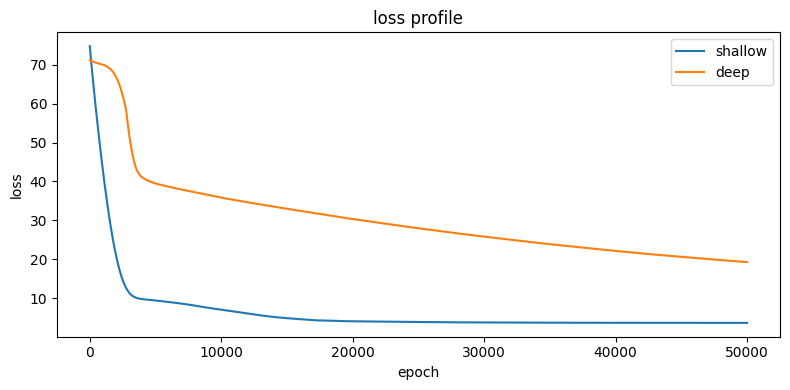

In [109]:
fig, ax = plt.subplots(1, 1 , figsize=(8, 4))
plot_loss(info_shallow, ax, title='loss profile', label='shallow' )
plot_loss(info_deep, ax, title='loss profile', label='deep' )

plt.legend()
plt.tight_layout()

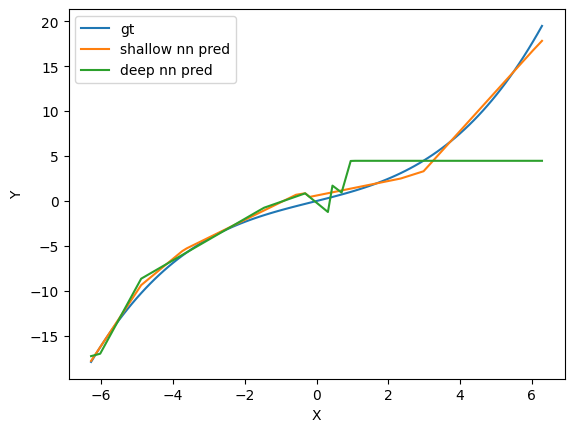

In [110]:
N = 100
X = torch.linspace(-2*torch.pi, 2*torch.pi, N).view(-1, 1)
Y = X + 0.02 * X ** 2 + 0.05 * X ** 3

y_pred_deep = deep_model(X).detach()
y_pred_shallow = shallow_model(X).detach()

fig = plt.figure()
plt.plot(X, Y, label='gt')
plt.plot(X, y_pred_shallow, label='shallow nn pred')
plt.plot(X, y_pred_deep, label='deep nn pred')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()